In [30]:
from sklearn.decomposition import KernelPCA
from sklearn.cross_validation import KFold
from sklearn import svm
import numpy as np
import math
import random
import math
from sklearn.metrics import confusion_matrix as CM

## One result

In [31]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

In [32]:
def IndOfSortedFea(feaInfo):
    """return sorted index of a list"""
    sortInfo=sorted(feaInfo,reverse=True)
    ##for test
    ##print sortInfo
    return [feaInfo.index(i) for i in sortInfo]
a=[3,4,6,2]
print IndOfSortedFea(a)

[2, 1, 0, 3]


In [33]:
def corDis(x,y):
    """
    calculate the correlation distance, given x and y calculate how similar the x and y is.
    return a value, 0 means x and y are independent, higher mean x are determinstic of y.
    """
    assert len(x)==len(y)
    n=len(x)
    a=np.zeros((n,n))
    b=np.zeros((n,n))
    ##calculate pair wise distance
    for i in xrange(n):
        for j in xrange(n):
            a[i,j]=np.linalg.norm(x[i]-x[j])
            b[i,j]=np.linalg.norm(y[i]-y[j])
    aRowMean=np.mean(a,axis=1)
    aColMean=np.mean(a,axis=0)
    bRowMean=np.mean(b,axis=1)
    bColMean=np.mean(b,axis=0)
    aMean=np.mean(a)
    bMean=np.mean(b)
    A=np.zeros((n,n))
    B=np.zeros((n,n))
    ##normalization
    for i in xrange(n):
        for j in xrange(n):
            A[i,j]=a[i,j]-aRowMean[i]-aColMean[j]+aMean
            B[i,j]=b[i,j]-bRowMean[i]-bColMean[j]+bMean
    cordis=0.
    for i in xrange(n):
        for j in xrange(n):
            cordis += A[i,j]*B[i,j]
    return cordis*(1./n**2)

In [34]:
#%matplotlib inline
from matplotlib import pyplot as plt
def plotFunction(x,y,text):
    n=x.shape[1]
    cols=2
    rows=int(math.ceil(n/2.))
    fig,ax=plt.subplots(ncols=cols,nrows=rows)
    if rows==1:
        for j in range(cols):
            if j<n:
                ax[j].scatter(x[:,j],y,c='b')
    else:
        for i in range(rows):
            for j in range(cols):
                if i*cols+j<n:
                    ax[i,j].scatter(x[:,i*cols+j],y,c='b')
                    #ax[i].title('x%d'%i,fontsize='small')
    plt.title(text)
    plt.show()


In [35]:
def crossValidation(x,y):
    """
    version 2
    according to the true y, predict
    greedy algorithm: first using index
    return
    """
    crossErrors=[]
    confusion_matrix=[]
    #svc=svm.LinearSVC()
    svc=svm.SVC(kernel='linear')
    kf = KFold(x.shape[0], n_folds=5,shuffle=True)
    for train,test in kf:
        svc.fit(x[train],y[train])
        prediction=svc.predict(x[test])
        crossErrors.append(((prediction!=y[test]).sum())/float(len(y[test])))
        confusion_matrix.append(CM(y[test],prediction))
    return np.mean(crossErrors),confusion_matrix

In [36]:
def layer_rbf(x,y,ga=0.0):
    """version 2"""
    kpca=KernelPCA(kernel='rbf',gamma=ga,n_components=x.shape[1])
    xT=kpca.fit_transform(x)
    rank=[]
    numOfFeatures=xT.shape[1]
    for i in xrange(numOfFeatures):
        rank.append(corDis(xT[:,i],y))
    feaSelected=IndOfSortedFea(rank)
    
    featureSelectedErrors=[]
    for i in xrange(numOfFeatures):
        crossErrors,cms=crossValidation(xT[:,feaSelected[:i+1]],y)
        featureSelectedErrors.append(crossErrors)
    choice=featureSelectedErrors.index(min(featureSelectedErrors))
    return xT[:,feaSelected[:choice+1]],featureSelectedErrors,cms,ga

In [37]:
def pretrain(x,y):
    rank=[]
    numOfFeatures=x.shape[1]
    for i in xrange(numOfFeatures):
        rank.append(corDis(x[:,i],y))
    feaSelected=IndOfSortedFea(rank)
    
    featureSelectedErrors=[]
    for i in xrange(numOfFeatures):
        crossErrors,cms=crossValidation(x[:,feaSelected[:i+1]],y)
        featureSelectedErrors.append(crossErrors)
    choice=featureSelectedErrors.index(min(featureSelectedErrors))
    return x[:,feaSelected[:choice+1]],featureSelectedErrors,cms 

In [63]:
def multi_layer_machine(x,y,layers=4):
    """
    Multi-layer machine
    """
    results=[]
    feaErrors=[]
    cms=[]
    gammas=[]
    
    ##pretrain processing
    result,featureError,cm=pretrain(x,y)
    gamma=0.1
    #
    results.append(result)
    feaErrors.append(featureError)
    cms.append(cm)
    gammas.append(gamma)
    
    for i in xrange(layers):
        ##one layer processing
        gamma=tuningParameter(feaErrors,gammas)
        result,featureError,cm,gamma=layer_rbf(result,y,gamma)
        ##append result
        results.append(results)
        feaErrors.append(featureError)
        cms.append(cm)
        gammas.append(gamma)
    return results,feaErrors,cms,gammas

In [64]:
def tuningParameter(feaErrors,gammas):
    if len(gammas)<2:
        gamma=5.0
    else:
        last=np.mean(feaErrors[len(feaErrors)-1])
        last_two=np.mean(feaErrors[len(feaErrors)-2])
        gamma=gammas[len(gammas)-1]*(1.0*abs(last-last_two)/last_two)
    if gamma>10.0:
        gamma=10.0
    return gamma    

In [65]:
from matplotlib import pyplot as plt
def plotdata(x,y):
    n=x.shape[1]
    fig,ax=plt.subplots(ncols=n,nrows=n)
    
    for i in xrange(n):
        for j in xrange(i+1):
            for t,color in zip(xrange(3),'rgb'):
                ax[i][j].scatter(x[y == t,i],x[y == t,j],c=color)
    plt.show()
#plotdata(x,y)

In [66]:
def plotErr(err):
    x=range(len(err))
    #y=[e/min(err) for e in err]
    plt.bar(x,err)
    plt.title('Error Bar_Chart')
    plt.show()

In [67]:
def printCM(cm):
    """
    print cm in a nice way
    """
    for i in cm:
        print i

In [68]:
iris=load_iris()
x=iris.data
y=iris.target

In [69]:
results,feaErrors,cms,gammas=multi_layer_machine(x,y,layers=5)

In [70]:
%matplotlib inline

In [75]:
for i in xrange(len(results)):
    print len(results[i])
#x=np.array(results[1])
    #plotdata(i,y)


150
6
6
6
6
6


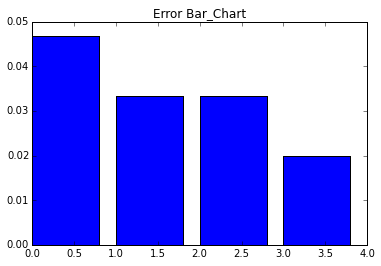

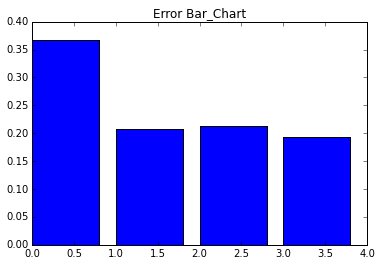

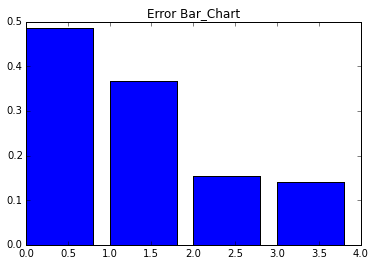

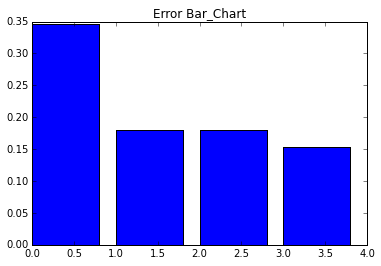

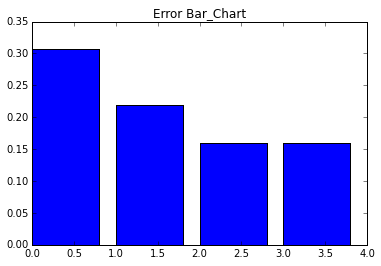

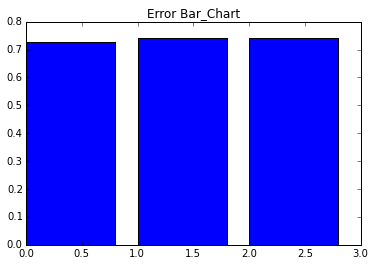

In [51]:
for i in feaErrors:
    plotErr(i)

In [52]:
for i in xrange(len(cms)):
    print "layer : %d" % i
    printCM(cms[i])
    

layer : 0
[[12  0  0]
 [ 0 10  0]
 [ 0  0  8]]
[[ 6  0  0]
 [ 0  9  1]
 [ 0  1 13]]
[[15  0  0]
 [ 0 11  0]
 [ 0  0  4]]
[[ 8  0  0]
 [ 0  7  1]
 [ 0  0 14]]
[[ 9  0  0]
 [ 0 11  0]
 [ 0  0 10]]
layer : 1
[[8 0 2]
 [0 9 3]
 [0 1 7]]
[[7 0 2]
 [0 9 3]
 [0 0 9]]
[[7 0 2]
 [0 6 5]
 [0 1 9]]
[[10  0  2]
 [ 0  8  0]
 [ 0  2  8]]
[[8 1 1]
 [0 7 0]
 [0 4 9]]
layer : 2
[[11  0  1]
 [ 0  8  1]
 [ 0  2  7]]
[[ 4  0  1]
 [ 0 12  1]
 [ 0  4  8]]
[[ 8  0  0]
 [ 0 10  2]
 [ 0  1  9]]
[[11  0  1]
 [ 0  7  1]
 [ 0  2  8]]
[[11  0  2]
 [ 0  6  2]
 [ 0  0  9]]
layer : 3
[[ 7  0  1]
 [ 0 12  1]
 [ 0  3  6]]
[[12  0  1]
 [ 0  6  2]
 [ 0  2  7]]
[[7 0 0]
 [0 9 2]
 [0 3 9]]
[[11  0  3]
 [ 0  9  1]
 [ 0  1  5]]
[[ 7  0  1]
 [ 0  7  1]
 [ 0  1 13]]
layer : 4
[[9 0 3]
 [0 7 2]
 [0 2 7]]
[[ 7  0  0]
 [ 0 10  2]
 [ 0  3  8]]
[[ 5  0  3]
 [ 0 10  0]
 [ 0  2 10]]
[[13  0  0]
 [ 0  9  1]
 [ 0  1  6]]
[[9 0 1]
 [0 7 2]
 [0 2 9]]
layer : 5
[[ 6  1  0]
 [ 4  3  0]
 [ 0 16  0]]
[[ 0  0 12]
 [ 0  0 10]
 [ 0  0  8]]
[[ 0

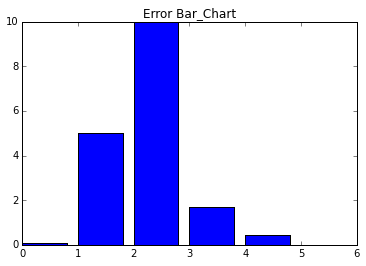

In [53]:
plotErr(gammas)